View and combine MODS spectrograph data.
--
A code block by Zach Stevens

In [1]:
import os
import matplotlib
import specutils
from matplotlib import pyplot as plt
from matplotlib.ticker import MaxNLocator, MultipleLocator, FormatStrFormatter, AutoMinorLocator
from specutils import Spectrum1D, SpectralRegion
from specutils.manipulation import (box_smooth, gaussian_smooth, trapezoid_smooth)
import astropy.io.fits as fits
import numpy as np
from astropy import units as u
from astropy.visualization import quantity_support
quantity_support()
from astropy.convolution import Box1DKernel
from specutils.manipulation import median_smooth
import fnmatch
import pandas as pd
import math


# Show the plots in the notebook
%matplotlib inline

## In the cell below, input the name of your object, along with its new flux value (calculated during your absolute flux calibration).

In [3]:
mainDirectory = r"C:\Users\13zac\OneDrive\Desktop\Research\Data/" #"D:/"

os.chdir(mainDirectory) 

#Settings for file reduction
#---------------------------

quasars = pd.read_csv('FinalDataFluxes.csv')
quasars.set_index('Object Name', inplace=True)

currentObject = "J1204"

newFluxVal = quasars.loc[currentObject, 'New Flux']
newFluxVal = float(newFluxVal)

if math.isnan(newFluxVal):
    newFluxVal = 1E-16
    print("Using arbitrary flux of 1e-16")

print("New Flux Value:", newFluxVal)

#--------------------
#imgExt is for when we have multiple objects in the slit - extensions go in increasing value from left to right according to 
#physical position within the slit. For the most part, this will remain at a value of 1, but when we want to analyze a different
#object, we will want to change this.
#------------------

imgExt_1b = quasars.loc[currentObject, 'imgExt_1b']
imgExt_1r = quasars.loc[currentObject, 'imgExt_1r']
imgExt_2b = quasars.loc[currentObject, 'imgExt_2b']
imgExt_2r = quasars.loc[currentObject, 'imgExt_2r']

mods1bGood = True

New Flux Value: 4.22e-17


In [4]:
quasars

,New Flux,imgExt_1b,imgExt_1r,imgExt_2b,imgExt_2r
Object Name,,,,,
J0742,1.100000e-16,1,1,1,1
J0742_AdjGal,NaN,3,2,3,2
J0742-2,1.100000e-16,1,1,1,1
J0751,2.830000e-17,1,1,1,2
J0800,8.910000e-17,1,1,1,1
J0807,5.780000e-17,1,1,1,1
J0832,3.330000e-17,1,1,1,1
J0950,6.850000e-17,1,1,1,1
J1037,1.480000e-16,1,1,1,1


Data extraction and first plot of each MODS spectra.
---

Your image extensions are (1, 1, 1, 1)


findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans.


<Figure size 432x288 with 0 Axes>

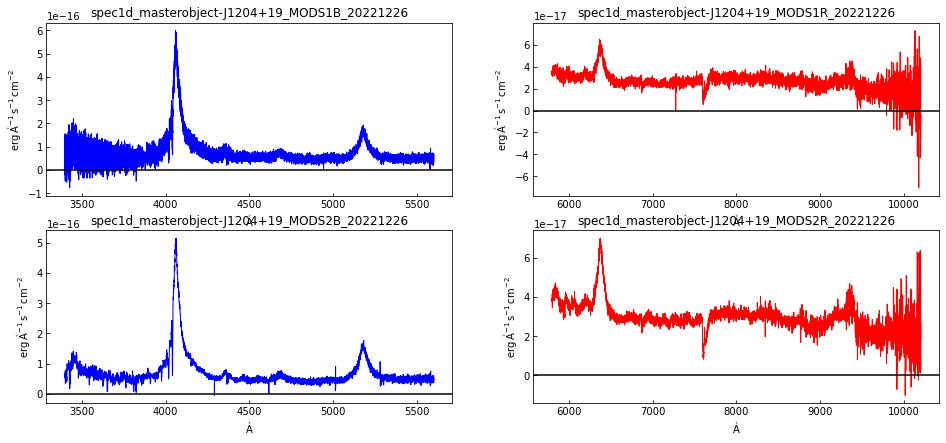

In [5]:
#Comparing mods files

print(f"Your image extensions are {imgExt_1b, imgExt_1r, imgExt_2b, imgExt_2r}")

numToTake = 1

#mods1b
os.chdir(mainDirectory + currentObject + "/mods1b/Science/")

for file in os.listdir('.'):
    if fnmatch.fnmatch(file, '*spec1d_masterobject*- Cropped.fits'):
        mods1b = file
#Working with J0742 for the meantime, this is the link to the SDSS info for it
hdu1b = fits.open(mods1b)
data1b = hdu1b[imgExt_1b].data
imhdr1b = hdu1b[imgExt_1b].header
#print(hdu[imgExt].header)
hdu1b.close()
lam1b = data1b['OPT_WAVE'] * u.AA
flux1b = data1b['OPT_FLAM'] * 10**-17 * u.Unit('erg cm-2 s-1 AA-1')
lam1b_plot = lam1b[::numToTake]
flux1b_plot = flux1b[::numToTake]
spec1b = Spectrum1D(spectral_axis=lam1b_plot, flux=flux1b_plot)


#mods1r
os.chdir(mainDirectory + currentObject + "/mods1r/Science/")

for file in os.listdir('.'):
    if fnmatch.fnmatch(file, '*spec1d_masterobject*.fits'):
        mods1r = file
        
hdu1r = fits.open(mods1r)
data1r = hdu1r[imgExt_1r].data
imhdr1r = hdu1r[imgExt_1r].header
# print(hdu[imgExt].header)
hdu1r.close()
lam1r = data1r['OPT_WAVE'] * u.AA
flux1r = data1r['OPT_FLAM'] * 10**-17 * u.Unit('erg cm-2 s-1 AA-1')
lam1r_plot = lam1r[::numToTake]
flux1r_plot = flux1r[::numToTake]
spec1r = Spectrum1D(spectral_axis=lam1r_plot, flux=flux1r_plot)

#mods2b
os.chdir(mainDirectory + currentObject + "/mods2b/Science/")

for file in os.listdir('.'):
    if fnmatch.fnmatch(file, '*spec1d_masterobject*- Cropped.fits'):
        mods2b = file
hdu2b = fits.open(mods2b)
data2b = hdu2b[imgExt_2b].data
imhdr2b = hdu2b[imgExt_2b].header
#print(hdu[imgExt].header)
hdu2b.close()
lam2b = data2b['OPT_WAVE'] * u.AA
flux2b = data2b['OPT_FLAM'] * 10**-17 * u.Unit('erg cm-2 s-1 AA-1')
lam2b_plot = lam2b[::numToTake]
flux2b_plot = flux2b[::numToTake]
spec2b = Spectrum1D(spectral_axis=lam2b_plot, flux=flux2b_plot)

#mods2r

if os.path.exists(mainDirectory + currentObject + "/mods2r/Science/"):

    os.chdir(mainDirectory + currentObject + "/mods2r/Science/")
    
    mods2rExists = True
    
    for file in os.listdir('.'):
        if fnmatch.fnmatch(file, '*spec1d_masterobject*.fits'):
            mods2r = file

    hdu2r = fits.open(mods2r)
    data2r = hdu2r[imgExt_2r].data
    imhdr2r = hdu2r[imgExt_2r].header
    #print(hdu[imgExt].header)
    hdu2r.close()
    lam2r = data2r['OPT_WAVE']
    flux2r = data2r['OPT_FLAM']
    lam2r_plot = lam2r[::numToTake] * u.AA
    flux2r_plot = flux2r[::numToTake] * 10**-17 * u.Unit('erg cm-2 s-1 AA-1')
    spec2r = Spectrum1D(spectral_axis=lam2r_plot, flux=flux2r_plot)
else:
    mods2rExists = False


# Matplotlib preferences
plt.close('all')
plt.clf()
#plt.ioff() # hides plots
plt.ion() # makes plots show up (needed for Jupyter)
plt.rcParams['xtick.direction']='in'
plt.rcParams['ytick.direction']='in'
plt.rc('font',family='sans-serif')
plt.rc('font', serif='Helvetica')
plt.rcParams['mathtext.fontset']='custom'
plt.rcParams['mathtext.rm']='Bitstream Vera Sans'
plt.rcParams['mathtext.it']='Bitstream Vera Sans:italic'
plt.rcParams['mathtext.bf']='Bitstream Vera Sans:bold'

# Set version to track testing
version = '1'

# Make the plot
fig, axs = plt.subplots(2, 2, figsize=(16,7))

axs[0, 0].step(spec1b.spectral_axis, spec1b.flux, color = "blue", linewidth=1.0)
# axs[0, 0].plot(lam1b_plot, flux1b_plot, marker='.', markersize=1, color='blue', linewidth=1.0, markeredgewidth=1.0, alpha=1.0)
axs[0, 0].set_title(mods1b[:-26])
axs[0, 0].axhline(y=0, color='black')

axs[1, 0].step(spec2b.spectral_axis, spec2b.flux, color = "blue", linewidth=1.0)
#axs[0, 1].plot(lam2b_plot, flux2b_plot, marker='.', markersize=1, color='blue', linewidth=1.0, markeredgewidth=1.0, alpha=1.0)
axs[1, 0].set_title(mods2b[:-26])
axs[1, 0].axhline(y=0, color='black')

axs[0, 1].step(spec1r.spectral_axis, spec1r.flux, color = "red", linewidth=1.0)
#axs[1, 0].plot(lam1r_plot, flux1r_plot, marker='.', markersize=1, color='red', linewidth=1.0, markeredgewidth=1.0, alpha=1.0)
axs[0, 1].set_title(mods1r[:-16])
axs[0, 1].axhline(y=0, color='black')


if mods2rExists:
    axs[1, 1].step(spec2r.spectral_axis, spec2r.flux, color = "red", linewidth=1.0)
    #axs[1, 1].plot(lam2r_plot, flux2r_plot, marker='.', markersize=1, color='red', linewidth=1.0, markeredgewidth=1.0, alpha=1.0)
    axs[1, 1].set_title(mods2r[:-16])
    axs[1, 1].axhline(y=0, color='black')
    
else:
    axs[1, 1].set_title('No Mods2r')
    axs[1, 1].axhline(y=0, color='black')
    
    

os.chdir(mainDirectory + currentObject + "/Final Spectra")
plt.savefig(str(currentObject) + '_modsImages.pdf', dpi=300)

In [6]:
##Attempting resampling process here
from specutils.manipulation import FluxConservingResampler, LinearInterpolatedResampler, SplineInterpolatedResampler

os.chdir(mainDirectory + currentObject + "/mods1b/Science/") #This was 2b, maybe makes a difference

for file in os.listdir('.'):
    if fnmatch.fnmatch(file, '*spec1d_masterobject*- Cropped.fits'):
        fitsfile = file

reMods1b = fits.open(fitsfile)
specdata = reMods1b[imgExt_1b].data
reMods1b.close()

reLam = specdata['OPT_WAVE'] * u.AA
reFlux = specdata['OPT_FLAM'] * 10**-17 * u.Unit('erg cm-2 s-1 AA-1')
input_spec = Spectrum1D(spectral_axis=reLam, flux=reFlux)

# #----------------------- #Adding in pre-fluxed for comparison

# os.chdir(r"C:\Users\13zac\OneDrive\Desktop\Research\Data/" + currentObject + "/mods2b/Science_Original/")

# for file in os.listdir('.'):
#     if fnmatch.fnmatch(file, '*spec1d_masterobject*.fits'):
#         originalFile = file

# reOriginal = fits.open(originalFile)
# specdataOrig = reOriginal[1].data
# print(reOriginal[1].data)
# reOriginal.close()

# reLamOrig = specdataOrig['OPT_WAVE'] * u.AA
# reFluxOrig = specdataOrig['OPT_FLAM'] * 10**-17 * u.Unit('erg cm-2 s-1 AA-1')
# input_spec_orig = Spectrum1D(spectral_axis=reLamOrig, flux=reFluxOrig)

## This cell sets up the pltModsXX files

In [7]:
smoothfactor = 9

# Open the file - blue!
os.chdir(mainDirectory + currentObject + "/mods1b/Science/")

for file in os.listdir('.'):
    if fnmatch.fnmatch(file, '*spec1d_masterobject*- Cropped.fits'):
        fitsfile = file

hdu = fits.open(fitsfile)
data = hdu[imgExt_1b].data
imhdr = hdu[imgExt_1b].header
#print(hdu[imgExt].header)
hdu.close()

lam = data['OPT_WAVE'] * u.AA
flux = data["OPT_FLAM"] * 10**-17 * u.Unit('erg cm-2 s-1 AA-1')

lam_plot = lam[::1]
flux_plot = flux[::1]

pltMods1b = Spectrum1D(spectral_axis=lam_plot, flux=flux_plot)
pltMods1b_smooth = median_smooth(pltMods1b, width=smoothfactor)


# Open the file - red!
os.chdir(mainDirectory + currentObject + "/mods1r/Science/")

for file in os.listdir('.'):
    if fnmatch.fnmatch(file, '*spec1d_masterobject*.fits'):
        fitsfile2 = file
#Working with J0742 for the meantime, this is the link to the SDSS info for it
hdu2 = fits.open(fitsfile2)
data2 = hdu2[imgExt_1r].data
imhdr2 = hdu2[imgExt_1r].header
#print(hdu[1].header)
hdu2.close()

lam2 = data2['OPT_WAVE'] * u.AA
flux2 = data2['OPT_FLAM'] * 10**-17 * u.Unit('erg cm-2 s-1 AA-1')

lam_plot2 = lam2[::1]
flux_plot2 = flux2[::1]

pltMods1r = Spectrum1D(spectral_axis=lam_plot2, flux=flux_plot2)
pltMods1r_smooth = median_smooth(pltMods1r, width=smoothfactor)


#open the file - mods2b!
os.chdir(mainDirectory + currentObject + "/mods2b/Science/")

for file in os.listdir('.'):
    if fnmatch.fnmatch(file, '*spec1d_masterobject*- Cropped.fits'):
        fitsfile2b = file

hdu2b = fits.open(fitsfile2b)
data2b = hdu2b[imgExt_2b].data
imhdr2b = hdu2b[imgExt_2b].header
#print(hdu[imgExt].header)
hdu2b.close()

lam2b = data2b['OPT_WAVE'] * u.AA
flux2b = data2b['OPT_FLAM'] * 10**-17 * u.Unit('erg cm-2 s-1 AA-1')

if currentObject == "J0800":
    flux2b = flux2b #* 0.27

lam_plot2b = lam2b[::1]
flux_plot2b = flux2b[::1]

pltMods2b = Spectrum1D(spectral_axis=lam_plot2b, flux=flux_plot2b)
pltMods2b_smooth = median_smooth(pltMods2b, width=smoothfactor)

    
#open the file - mods2r!
if mods2rExists:
    os.chdir(mainDirectory + currentObject + "/mods2r/Science/")

    for file in os.listdir('.'):
        if fnmatch.fnmatch(file, '*spec1d_masterobject*.fits'):
            fitsfile2r = file

    hdu2r = fits.open(fitsfile2r)
    data2r = hdu2r[imgExt_2r].data
    imhdr2r = hdu2r[imgExt_2r].header
    #print(hdu[imgExt].header)
    hdu2r.close()

    lam2r = data2r['OPT_WAVE'] * u.AA
    flux2r = data2r['OPT_FLAM'] * 10**-17 * u.Unit('erg cm-2 s-1 AA-1')

    lam_plot2r = lam2r[::1]
    flux_plot2r = flux2r[::1]

    pltMods2r = Spectrum1D(spectral_axis=lam_plot2r, flux=flux_plot2r)
    pltMods2r_smooth = median_smooth(pltMods2r, width=smoothfactor)
    
else:
    pltMods2r = Spectrum1D(spectral_axis=np.arange(5800, 10200) * u.micron, flux=np.zeros(4400)*u.Unit('erg cm-2 s-1 AA-1'))
    


# Open the file - SDSS!

try:
    SDSSexists = True
    os.chdir(mainDirectory + currentObject + "/Final Spectra/")

    # Extract data for plotting
    if currentObject != "J1514":

        for file in os.listdir('.'):
            if fnmatch.fnmatch(file, '*spec*.fits'):
                fitsfile3 = file

        hdu3 = fits.open(fitsfile3)
        data3 = hdu3[1].data
        imhdr3 = hdu3[0].header

        # print(imhdr3)
        hdu3.close()

        lam3 = 10.**(data3['loglam']) * u.AA

        flux3 = data3['flux'] * 10**-17 * u.Unit('erg cm-2 s-1 AA-1')

    else:

        SDSSdata = pd.read_csv('spec232923_0205.csv')
    #     print(SDSSdata["Spectral_Value"])
        lam3 = SDSSdata['Spectral_Value'].to_numpy() * u.AA
        flux3 = SDSSdata['Flux_Value'].to_numpy() * 10**-17 * u.Unit('erg cm-2 s-1 AA-1')
        print("Yeah it's this one")

    lam_plot3 = lam3[::1]
    flux_plot3 = flux3[::1]


    pltSDSS = Spectrum1D(spectral_axis=lam_plot3, flux=flux_plot3)
    pltSDSS_smooth = median_smooth(pltSDSS, width=smoothfactor)
    print("SDSS read success")
except:
    SDSSexists = False
    print("SDSS read failure")

SDSS read success


### Applying the boxcar smooth and sigma clipping

In [8]:
# Source for following code: https://github.com/thespacedoctor/fundamentals/blob/master/fundamentals/stats/rolling_window_sigma_clip.py

def rolling_window_sigma_clip(array, clippingSigma, windowSize):
    """*given a sorted list of values, median sigma-clip values based on a window of values either side of each value (rolling window) and return the array mask*

    **Key Arguments:**

    - `array` -- the array to clean up (arrays of length < 5 are not clipped but returned unmasked)
    - `clippingSigma` -- the minimum sigma to clip (using median-absolute distribution as sigma proxy)
    - `windowSize` -- the size of the window to use when calculating the median distribution (window of 11 will use 5 values each side of the value in question)

    **Usage:**

    ```python
    from fundamentals.stats import rolling_window_sigma_clip
    arrayMask = rolling_window_sigma_clip(
        log=self.log,
        array=myArray,
        clippingSigma=2.2,
        windowSize=11)

    ## JUST KEEP UNMASKED VALUES
    try:
        myArray = [e for e, m in zip(
            myArray, arrayMask) if m == False]
    except:
        myArray = []
    ```           
    """
    from astropy.stats import sigma_clip, mad_std

    midWindow = int((windowSize + 1) / 2)
    # ACCOMODATE SMALL LIST SIZES
    if len(array) < 5:
        return len(array) * [False]
    elif len(array) < windowSize:
        masked = sigma_clip(
            array, sigma_lower=clippingSigma, sigma_upper=clippingSigma, maxiters=7, cenfunc='median', stdfunc=mad_std)
        return list(masked.mask)
    startOfWindow = 0
    endOfWindow = windowSize
    maskedArray = []
    dataIndex = 0
    while len(array) >= endOfWindow:
        arrayWindow = array[startOfWindow:endOfWindow]
        startOfWindow += 1
        endOfWindow += 1
        masked = sigma_clip(
            arrayWindow, sigma_lower=clippingSigma, sigma_upper=clippingSigma, maxiters=7, cenfunc='median', stdfunc=mad_std)

        if dataIndex == 0:
            # 0,1,2...midWindow-1
            maskedArray += list(masked.mask)[0:midWindow]
            dataIndex += midWindow
        elif len(array) == endOfWindow - 1:
            # -midWindow...-2,-1
            maskedArray += list(masked.mask)[-midWindow:]
            dataIndex += midWindow
        else:
            maskedArray += [list(masked.mask)[midWindow - 1]]
            dataIndex += 1
    return maskedArray

import copy
def clip_spectrum(spec, sigma):
    difference = Spectrum1D(spectral_axis=spec.spectral_axis, flux=copy.deepcopy(spec.flux))
    newFlux = rolling_window_sigma_clip(
            array=difference.flux,
            clippingSigma=sigma,
            windowSize=31)
    for i in range(len(difference.flux)):
        if newFlux[i] and (i+2) <= len(spec.spectral_axis) and (i-2) >= 0:
            difference.flux[i] = (difference.flux[i-2] + difference.flux[i+2])/2
        else:
            difference.flux[i] = copy.deepcopy(spec.flux[i])

    return difference, spec

# pltMods1b = clip_spectrum(pltMods1b)
# pltMods1r = clip_spectrum(pltMods1r)
# pltMods2b = clip_spectrum(pltMods2b)
# pltMods2r = clip_spectrum(pltMods2r)


#### Lots of graphs :)

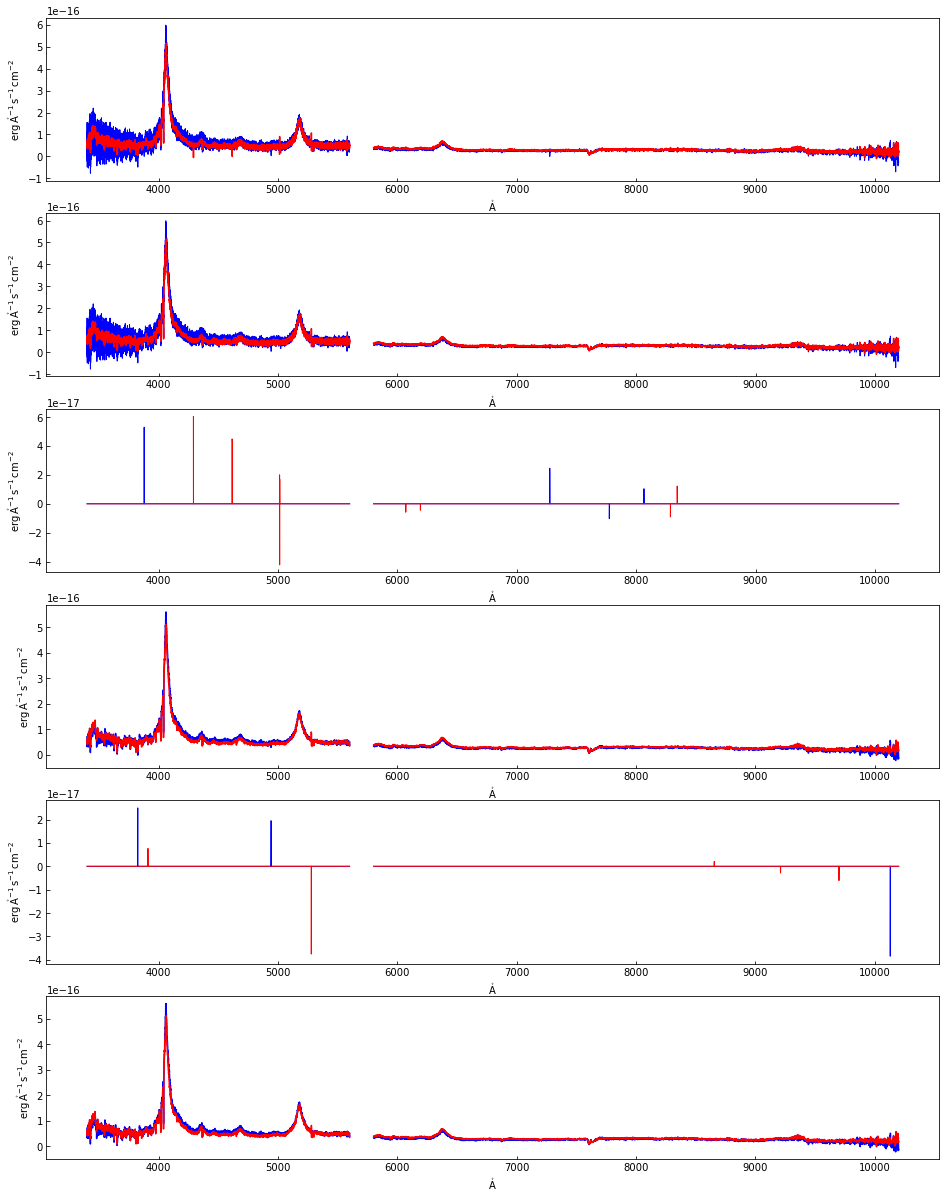

In [9]:
fig, axs = plt.subplots(6, 1, figsize=(16,21))
    
    
# differenceSpec = Spectrum1D(spectral_axis=pltMods2b.spectral_axis, flux=pltMods2b.flux) 
  
firstClipMods1b, xpltMods1b = clip_spectrum(pltMods1b, 5)
firstClipMods1r, xpltMods1r = clip_spectrum(pltMods1r, 5)
firstClipMods2b, xpltMods2b = clip_spectrum(pltMods2b, 5)
if mods2rExists:
    firstClipMods2r, xpltMods2r = clip_spectrum(pltMods2r, 5)

if mods1bGood:
    axs[0].step(xpltMods1b.spectral_axis, xpltMods1b.flux, color = "blue", linewidth=1.0)
axs[0].step(xpltMods1r.spectral_axis, xpltMods1r.flux, color = "blue", linewidth=1.0)
axs[0].step(xpltMods2b.spectral_axis, xpltMods2b.flux, color = "red")
if mods2rExists:
    axs[0].step(xpltMods2r.spectral_axis, xpltMods2r.flux, color = "red")

if mods1bGood:
    axs[1].step(firstClipMods1b.spectral_axis, firstClipMods1b.flux, color = "blue", linewidth=1.0)
axs[1].step(firstClipMods1r.spectral_axis, firstClipMods1r.flux, color = "blue", linewidth=1.0)
axs[1].step(firstClipMods2b.spectral_axis, firstClipMods2b.flux, color = "red")
if mods2rExists:
    axs[1].step(firstClipMods2r.spectral_axis, firstClipMods2r.flux, color = "red")

smoothedFluxMods1b = box_smooth(firstClipMods1b, width=2)[1:]
smoothedFluxMods1r = box_smooth(firstClipMods1r, width=2)[1:]
smoothedFluxMods2b = box_smooth(firstClipMods2b, width=2)[1:]
if mods2rExists:
    smoothedFluxMods2r = box_smooth(firstClipMods2r, width=2)[1:]

if mods1bGood:
    axs[2].step(xpltMods1b.spectral_axis, firstClipMods1b.flux-xpltMods1b.flux, color = "blue", linewidth=1.0)
axs[2].step(xpltMods1r.spectral_axis, firstClipMods1r.flux-xpltMods1r.flux, color = "blue", linewidth=1.0)
axs[2].step(xpltMods2b.spectral_axis, firstClipMods2b.flux-xpltMods2b.flux, color = "red", linewidth=1.0)
if mods2rExists:
    axs[2].step(xpltMods2r.spectral_axis, firstClipMods2r.flux-xpltMods2r.flux, color = "red", linewidth=1.0)

if mods1bGood: 
    axs[3].step(smoothedFluxMods1b.spectral_axis, smoothedFluxMods1b.flux, color = "blue")
axs[3].step(smoothedFluxMods1r.spectral_axis, smoothedFluxMods1r.flux, color = "blue")
axs[3].step(smoothedFluxMods2b.spectral_axis, smoothedFluxMods2b.flux, color = "red")
if mods2rExists:
    axs[3].step(smoothedFluxMods2r.spectral_axis, smoothedFluxMods2r.flux, color = "red")
    
finalMods1b, xxpltMods1b = clip_spectrum(smoothedFluxMods1b, 5)
finalMods1r, xxpltMods1r = clip_spectrum(smoothedFluxMods1r, 5)
finalMods2b, xxpltMods2b = clip_spectrum(smoothedFluxMods2b, 5)
if mods2rExists:
    finalMods2r, xxpltMods2r = clip_spectrum(smoothedFluxMods2r, 5)

if mods1bGood:
    axs[4].step(finalMods1b.spectral_axis, finalMods1b.flux-xxpltMods1b.flux, color = "blue", linewidth=1.0)
axs[4].step(finalMods1r.spectral_axis, finalMods1r.flux-xxpltMods1r.flux, color = "blue", linewidth=1.0)
axs[4].step(finalMods2b.spectral_axis, finalMods2b.flux-xxpltMods2b.flux, color = "red", linewidth=1.0)
if mods2rExists:
    axs[4].step(finalMods2r.spectral_axis, finalMods2r.flux-xxpltMods2r.flux, color = "red", linewidth=1.0)

if mods1bGood:
    axs[5].step(finalMods1b.spectral_axis, finalMods1b.flux, color = "blue")
axs[5].step(finalMods1r.spectral_axis, finalMods1r.flux, color = "blue")
axs[5].step(finalMods2b.spectral_axis, finalMods2b.flux, color = "red")
if mods2rExists:
    axs[5].step(finalMods2r.spectral_axis, finalMods2r.flux, color = "red")
    
    
#Eventually, make whatever "final" spectrum we're using be called "smoothedFluxModsXX", so that it carries 
#through to the rest of the code



# xrangeVals = (3400, 3550) 
# axs[0].set_xlim(xrangeVals)
# axs[1].set_xlim(xrangeVals)
# axs[2].set_xlim(xrangeVals)
# axs[3].set_xlim(xrangeVals)
# axs[4].set_xlim(xrangeVals)
# axs[5].set_xlim(xrangeVals)

# yrangeVals = (0, 1.5e-16)
# axs[0].set_ylim(yrangeVals)
# axs[1].set_ylim(yrangeVals)
# axs[2].set_ylim(yrangeVals)
# axs[3].set_ylim(yrangeVals)

# Resampling

C:\Users\13zac\anaconda3\lib\site-packages\astropy\units\quantity.py:613: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


<Figure size 432x288 with 0 Axes>

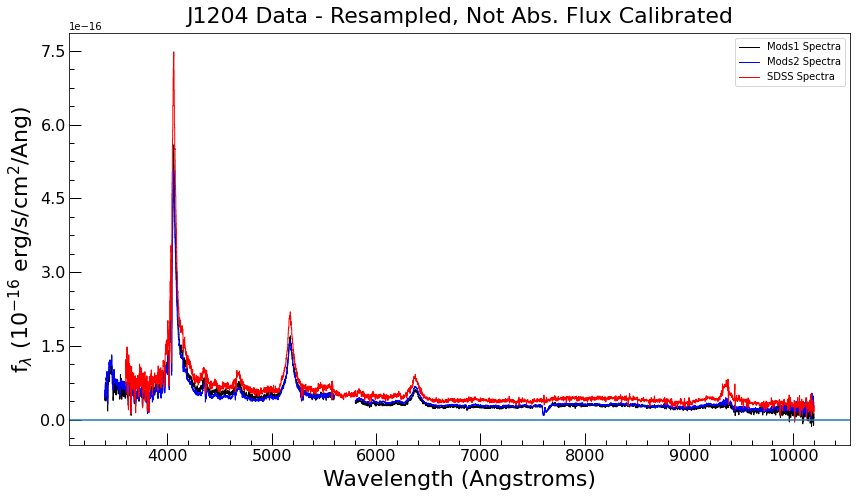

In [10]:
#RESAMPLED ONE

#resampled
new_disp_grid = np.arange(3400, 10200, 1.5) * u.AA        #do steps of 1.5 
fluxconResamp = FluxConservingResampler() #LinearInterpolatedResampler()
new_spec_int_resamp = fluxconResamp(input_spec, new_disp_grid)


#YOU'LL WANT TO RENAME THESE TO FLUXCON, NOT INT-RESAMP
#Before smoothing, where it says smoothedFluxMods1b now, it used to be pltModsXX, just as a note

if SDSSexists:
    SDSSIntResamp = fluxconResamp(pltSDSS, new_disp_grid)
    
Mods1bResamp = fluxconResamp(finalMods1b, new_disp_grid)
Mods1rResamp = fluxconResamp(finalMods1r, new_disp_grid)
Mods2bResamp = fluxconResamp(finalMods2b, new_disp_grid)

if mods2rExists:
    Mods2rResamp = fluxconResamp(finalMods2r, new_disp_grid)


# Matplotlib preferences
plt.close('all')
plt.clf()
#plt.ioff() # hides plots
plt.ion() # makes plots show up (needed for Jupyter)
plt.rcParams['xtick.direction']='in'
plt.rcParams['ytick.direction']='in'
plt.rc('font',family='sans-serif')
plt.rc('font', serif='Helvetica')
plt.rcParams['mathtext.fontset']='custom'
plt.rcParams['mathtext.rm']='Bitstream Vera Sans'
plt.rcParams['mathtext.it']='Bitstream Vera Sans:italic'
plt.rcParams['mathtext.bf']='Bitstream Vera Sans:bold'

f, ax = plt.subplots(figsize=(12,7))

#If you just want to see Mods1 or Mods2, comment out others here in these lines below.

if mods1bGood:
    ax.step(Mods1bResamp.spectral_axis, Mods1bResamp.flux, color = "black",  linewidth=1, label="Mods1 Spectra")
ax.step(Mods1rResamp.spectral_axis, Mods1rResamp.flux, color = "black",  linewidth=1)
ax.step(Mods2bResamp.spectral_axis, Mods2bResamp.flux, color = "blue",  linewidth=1, label="Mods2 Spectra")
if mods2rExists:
    ax.step(Mods2rResamp.spectral_axis, Mods2rResamp.flux, color = "blue",  linewidth=1)
else:
    ax.axhline(y=0.1e-18, color = "orange", label="No Mods2r")

if SDSSexists:
    ax.step(SDSSIntResamp.spectral_axis, SDSSIntResamp.flux, color = "red",  linewidth=1, label="SDSS Spectra")




#plt.axvline(4557.22, color='red', linewidth=1, alpha=0.5, label='Mg II 2799')
plt.xlabel(r'Wavelength (Angstroms)',fontsize=22, labelpad=6)
plt.ylabel(r'f$_{\lambda}$ (10$^{-16}$ erg/s/cm$^2$/Ang)',fontsize=22, labelpad=4)
plt.tick_params(which='major', axis='both',length=12, width=1, labelsize=16)
plt.tick_params(which='minor', axis='both',length=5, width=1, labelsize=16)
plt.gca().xaxis.set_major_locator(MaxNLocator(nbins=8, prune='lower'))
plt.gca().yaxis.set_major_locator(MaxNLocator(nbins=6))
# plt.xlim(3400, 4000)       #3500, 8800
plt.axhline(y=0)
plt.legend(loc="upper right")
# plt.ylim(0.6e-16,1.8e-16)
plt.annotate('SDSS', xy = (0, 0), xytext = (0.5, 0.5), size=22, textcoords = 'axes fraction', ha = 'left', va = 'center', color='black')
plt.title(str(currentObject) + ' Data - Resampled, Not Abs. Flux Calibrated',fontsize=22, y=1.01)
plt.minorticks_on()
plt.tight_layout()
#plt.savefig('J0742_SDSS_spectrum_v' + version + '.pdf', dpi=300) 

os.chdir(mainDirectory + currentObject + "/Final Spectra")

<Figure size 432x288 with 0 Axes>

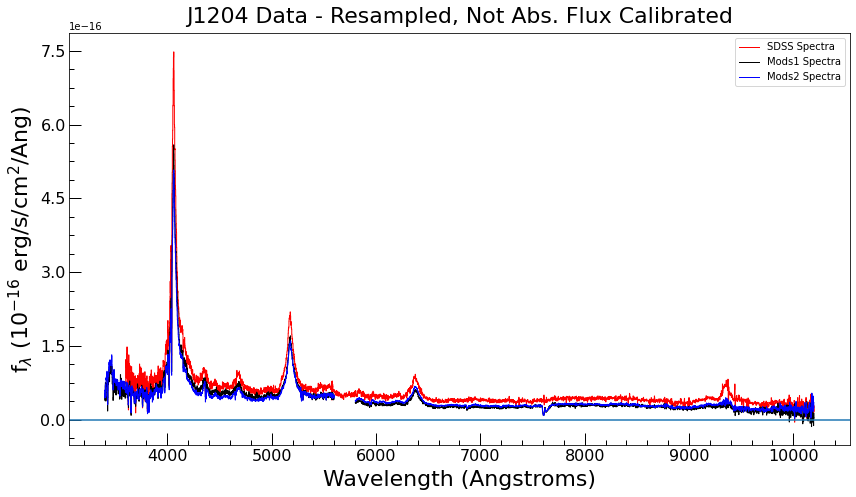

In [11]:
# Matplotlib preferences
plt.close('all')
plt.clf()
#plt.ioff() # hides plots
plt.ion() # makes plots show up (needed for Jupyter)
plt.rcParams['xtick.direction']='in'
plt.rcParams['ytick.direction']='in'
plt.rc('font',family='sans-serif')
plt.rc('font', serif='Helvetica')
plt.rcParams['mathtext.fontset']='custom'
plt.rcParams['mathtext.rm']='Bitstream Vera Sans'
plt.rcParams['mathtext.it']='Bitstream Vera Sans:italic'
plt.rcParams['mathtext.bf']='Bitstream Vera Sans:bold'

f, ax = plt.subplots(figsize=(12,7))

#If you just want to see Mods1 or Mods2, comment out others here in these lines below.

if SDSSexists:
    ax.step(SDSSIntResamp.spectral_axis, SDSSIntResamp.flux, color = "red",  linewidth=1, label="SDSS Spectra")

if mods1bGood:
    ax.step(Mods1bResamp.spectral_axis, Mods1bResamp.flux, color = "black",  linewidth=1, label="Mods1 Spectra")
ax.step(Mods1rResamp.spectral_axis, Mods1rResamp.flux, color = "black",  linewidth=1)
ax.step(Mods2bResamp.spectral_axis, Mods2bResamp.flux, color = "blue",  linewidth=1, label="Mods2 Spectra")
if mods2rExists:
    ax.step(Mods2rResamp.spectral_axis, Mods2rResamp.flux, color = "blue",  linewidth=1)
else:
    ax.axhline(y=0.1e-18, color = "orange", label="No Mods2r")






#plt.axvline(4557.22, color='red', linewidth=1, alpha=0.5, label='Mg II 2799')
plt.xlabel(r'Wavelength (Angstroms)',fontsize=22, labelpad=6)
plt.ylabel(r'f$_{\lambda}$ (10$^{-16}$ erg/s/cm$^2$/Ang)',fontsize=22, labelpad=4)
plt.tick_params(which='major', axis='both',length=12, width=1, labelsize=16)
plt.tick_params(which='minor', axis='both',length=5, width=1, labelsize=16)
plt.gca().xaxis.set_major_locator(MaxNLocator(nbins=8, prune='lower'))
plt.gca().yaxis.set_major_locator(MaxNLocator(nbins=6))
# plt.xlim(3400, 5600)       #3500, 8800
plt.axhline(y=0)
plt.legend(loc="upper right")
# plt.ylim(0.6e-16,1.8e-16)
plt.annotate('SDSS', xy = (0, 0), xytext = (0.5, 0.5), size=22, textcoords = 'axes fraction', ha = 'left', va = 'center', color='black')
plt.title(str(currentObject) + ' Data - Resampled, Not Abs. Flux Calibrated',fontsize=22, y=1.01)
plt.minorticks_on()
plt.tight_layout()
#plt.savefig('J0742_SDSS_spectrum_v' + version + '.pdf', dpi=300) 

os.chdir(mainDirectory + currentObject + "/Final Spectra")

# Absolute flux adjustment

using r-band


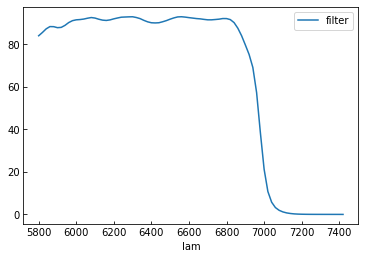

In [12]:
os.chdir(r"C:\Users\13zac\OneDrive\Desktop\Research\Codework")
if mods2rExists:
    color_filter = pd.read_csv('sdss_r_mods1.txt', delim_whitespace=True)
    color_filter['lam'] = color_filter['lam'].apply(lambda x: x * 10)
    color_filter = color_filter[color_filter['lam'] >= 5800]
    print("using r-band")

else:
    color_filter = pd.read_csv('sdss_g_mods1.txt', delim_whitespace=True)
    color_filter['lam'] = color_filter['lam'].apply(lambda x: x * 10)
#     color_filter.plot(x="lam", y="dichroic")
    print("using g-band")

color_filter.plot(x="lam", y="filter")

from specutils.manipulation import LinearInterpolatedResampler

filter_Spec = Spectrum1D(spectral_axis=color_filter["lam"].values * u.AA, flux=color_filter["dichroic"].values * u.Unit('erg cm-2 s-1 AA-1'))

linearResamp = LinearInterpolatedResampler()
filter_SpecResamp = linearResamp(filter_Spec, new_disp_grid)

total_flux = np.nansum(filter_SpecResamp.flux)

Mods1rFlux: 3.12064496104852e-17 erg / (Angstrom cm2 s)
Mods1 Ratio: 1.352284560619194
Mods2rFlux: 3.538741699630519e-17 erg / (Angstrom cm2 s)
Mods2 Ratio: 1.192514277162589


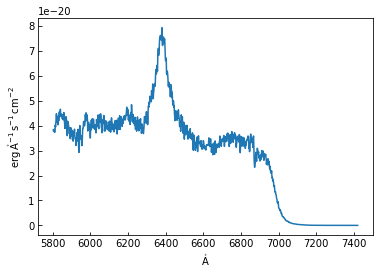

In [13]:
from scipy import interpolate as itp

if mods2rExists:
    M1rxFlux = Spectrum1D(spectral_axis=Mods1rResamp.spectral_axis, flux=copy.deepcopy(Mods1rResamp.flux))
    for i in range(len(filter_SpecResamp.flux)):
        M1rxFlux.flux[i] = (filter_SpecResamp.flux[i]/total_flux) * Mods1rResamp.flux[i]
        
    plt.plot(M1rxFlux.spectral_axis, M1rxFlux.flux)

    Mods1rFlux = np.nansum(M1rxFlux.flux)
    print(f"Mods1rFlux: {Mods1rFlux}")
    redRatio = (newFluxVal/Mods1rFlux).value
    print(f"Mods1 Ratio: {redRatio}")
    
    M2rxFlux = Spectrum1D(spectral_axis=Mods2rResamp.spectral_axis, flux=copy.deepcopy(Mods2rResamp.flux))
    for i in range(len(filter_SpecResamp.flux)):
        M2rxFlux.flux[i] = (filter_SpecResamp.flux[i]/total_flux) * Mods2rResamp.flux[i]

    Mods2rFlux = np.nansum(M2rxFlux.flux)
    print(f"Mods2rFlux: {Mods2rFlux}")
    Mods2redRatio = (newFluxVal/Mods2rFlux).value
    print("Mods2 Ratio: " + str(Mods2redRatio))
else:
    M1bxFlux = Spectrum1D(spectral_axis=Mods1bResamp.spectral_axis, flux=copy.deepcopy(Mods1bResamp.flux))
    for i in range(len(filter_SpecResamp.flux)):
        M1bxFlux.flux[i] = (filter_SpecResamp.flux[i]/total_flux) * Mods1bResamp.flux[i]
        
    plt.plot(M1bxFlux.spectral_axis, M1bxFlux.flux)

    Mods1bFlux = np.nansum(M1bxFlux.flux)
    print(Mods1bFlux)
    redRatio = ((newFluxVal)/Mods1bFlux).value
    print(f"1b Ratio: {redRatio}")
    
    M2bxFlux = Spectrum1D(spectral_axis=Mods2bResamp.spectral_axis, flux=copy.deepcopy(Mods2bResamp.flux))
    for i in range(len(filter_SpecResamp.flux)):
        M2bxFlux.flux[i] = (filter_SpecResamp.flux[i]/total_flux) * Mods2bResamp.flux[i]

    Mods2bFlux = np.nansum(M2bxFlux.flux)
    print(Mods2bFlux)
    Mods2redRatio = (newFluxVal/Mods2bFlux).value
    print(f"2b Ratio: {Mods2redRatio}")

# Implementing absolute flux value

<Figure size 432x288 with 0 Axes>

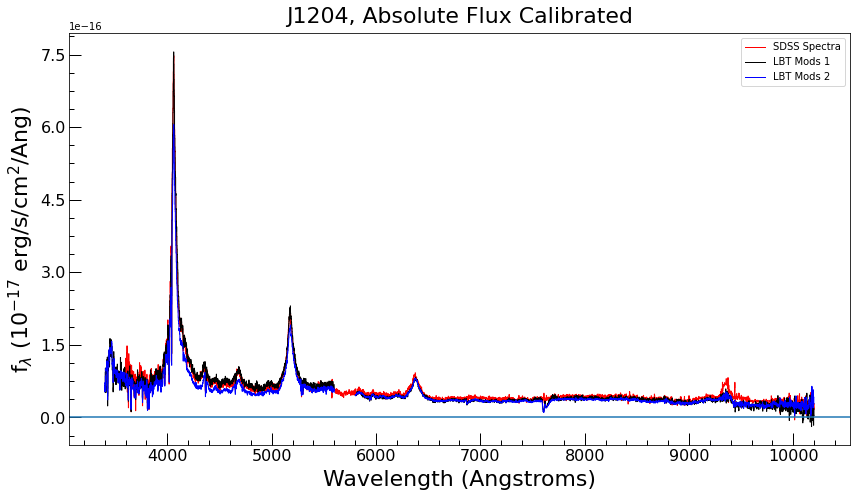

In [20]:
# Matplotlib preferences
plt.close('all')
plt.clf()
#plt.ioff() # hides plots
plt.ion() # makes plots show up (needed for Jupyter)
plt.rcParams['xtick.direction']='in'
plt.rcParams['ytick.direction']='in'
plt.rc('font',family='sans-serif')
plt.rc('font', serif='Helvetica')
plt.rcParams['mathtext.fontset']='custom'
plt.rcParams['mathtext.rm']='Bitstream Vera Sans'
plt.rcParams['mathtext.it']='Bitstream Vera Sans:italic'
plt.rcParams['mathtext.bf']='Bitstream Vera Sans:bold'

# Set version to track testing
version = '1'

# Make the plot
# fig = plt.figure(figsize=(12,5.5))
# ax = fig.add_subplot(1,1,1)

f, ax = plt.subplots(figsize=(12,7))

# #plotting blue end of the spectrum
# plt.plot(lam_plot, flux_plot, marker='.', markersize=1, color='k', linewidth=1.0, markeredgewidth=1.0, alpha=1.0)
# #plotting red end of the spectrum
# plt.plot(lam_plot2, flux_plot2, marker='.', markersize=1, color='k', linewidth=1.0, markeredgewidth=1.0, alpha=1.0)
# #plotting SDSS
# plt.plot(lam_plot3, flux_plot3, marker='.', markersize=1, color='red', linewidth=1.0, markeredgewidth=1.0, alpha=1.0)

if SDSSexists:
    ax.step(SDSSIntResamp.spectral_axis, SDSSIntResamp.flux, color = "red",  linewidth=1, label="SDSS Spectra")

if mods1bGood:
    ax.step(Mods1bResamp.spectral_axis, redRatio * Mods1bResamp.flux, color = "black",  linewidth=1, label="LBT Mods 1")
ax.step(Mods1rResamp.spectral_axis, redRatio * Mods1rResamp.flux, color = "black",  linewidth=1)
ax.step(Mods2bResamp.spectral_axis, Mods2redRatio * Mods2bResamp.flux, color = "blue",  linewidth=1, label="LBT Mods 2")
if mods2rExists:
    ax.step(Mods2rResamp.spectral_axis, Mods2redRatio * Mods2rResamp.flux, color = "blue",  linewidth=1)
else:
    ax.axhline(y=0.1e-18, color = "orange", label="No Mods2r")



# plt.axvline(4557.22, color='red', linewidth=1, alpha=0.5, label='Mg II 2799')
plt.xlabel(r'Wavelength (Angstroms)',fontsize=22, labelpad=6)
plt.ylabel(r'f$_{\lambda}$ (10$^{-17}$ erg/s/cm$^2$/Ang)',fontsize=22, labelpad=4)
plt.legend(loc="upper right")
plt.tick_params(which='major', axis='both',length=12, width=1, labelsize=16)
plt.tick_params(which='minor', axis='both',length=5, width=1, labelsize=16)
plt.gca().xaxis.set_major_locator(MaxNLocator(nbins=8, prune='lower'))
plt.gca().yaxis.set_major_locator(MaxNLocator(nbins=6))
# plt.xlim(3400, 5600)  #3400, 8800
# plt.ylim(0, 2e-16)
plt.axhline(y=0)
# plt.axhline(y=newFluxVal*10**-17)
# plt.axvline(x=fluxWav)
plt.legend(loc="upper right")
#plt.ylim(-5,10)
plt.annotate('SDSS', xy = (0, 0), xytext = (0.5, 0.5), size=22, textcoords = 'axes fraction', ha = 'left', va = 'center', color='black')
plt.title(str(currentObject) + ', Absolute Flux Calibrated',fontsize=22, y=1.01)
plt.minorticks_on()
plt.tight_layout()
#plt.savefig('J0742_SDSS_spectrum_v' + version + '.pdf', dpi=300) 

os.chdir(mainDirectory + currentObject + "/Final Spectra")
plt.savefig(str(currentObject) + 'AbsoluteFluxCalibrated.pdf', dpi=300)

# Creation of weighting factors

In [15]:
#This block will help combine the flux data with snr
from specutils.analysis import snr_derived
from specutils.spectra import SpectralRegion

#https://specutils.readthedocs.io/en/stable/analysis.html

if mods1bGood:
    SNR1 = snr_derived(Mods1bResamp, region = SpectralRegion(5000*u.AA, 5400*u.AA))
else:
    SNR1 = snr_derived(Mods1rResamp, region = SpectralRegion(5800*u.AA, 6000*u.AA))
    
SNR2 = snr_derived(Mods2bResamp, region = SpectralRegion(5000*u.AA, 5400*u.AA))
print(f'Mods1 SNR: {SNR1}')
print(f'Mods2 SNR: {SNR2}')

w1 = float((SNR1**2)/((SNR1**2)+(SNR2**2)))
w2 = float((SNR2**2)/((SNR1**2)+(SNR2**2)))

print("W1: " + str(w1) +"\nW2: " + str(w2))

if mods1bGood:
    modsBlueFlux = (w1 * redRatio * Mods1bResamp.flux) + (w2 * Mods2redRatio * Mods2bResamp.flux)
else: 
    modsBlueFlux = redRatio * Mods2bResamp.flux
    print("Just used mods2 for Blue")

if mods2rExists:
    modsRedFlux = (w1 * redRatio * Mods1rResamp.flux) + (w2 * Mods2redRatio * Mods2rResamp.flux)
    print("Combined Red Data")
else:
    modsRedFlux = redRatio * Mods1rResamp.flux
    print("Just used mods1 for Red")

Mods1 SNR: 22.220167419244312
Mods2 SNR: 23.721446917527537
W1: 0.46735687051028063
W2: 0.5326431294897194
Combined Red Data


# Final combination with weighting factors

In [16]:
# print(len(modsBlueFlux))
# print(type(modsBlueFlux))
# print(len(modsRedFlux))
# print(len(SDSSIntResamp.spectral_axis))

finalSpec = Spectrum1D(spectral_axis=np.arange(5800, 10200) * u.AA, flux=np.zeros(4400)*u.Unit('erg cm-2 s-1 AA-1'))
finalSpecResamp = fluxconResamp(finalSpec, new_disp_grid)

#finalSpecResamp = modsBlueFlux + modsRedFlux


for i in range(len(new_disp_grid)):
    finalSpecResamp.flux[i] = 0
    if i <= 1500:
        finalSpecResamp.flux[i] = modsBlueFlux[i]
    if i > 1500:
        finalSpecResamp.flux[i] = modsRedFlux[i]

C:\Users\13zac\anaconda3\lib\site-packages\astropy\units\quantity.py:613: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


### Final Spectrum Graph

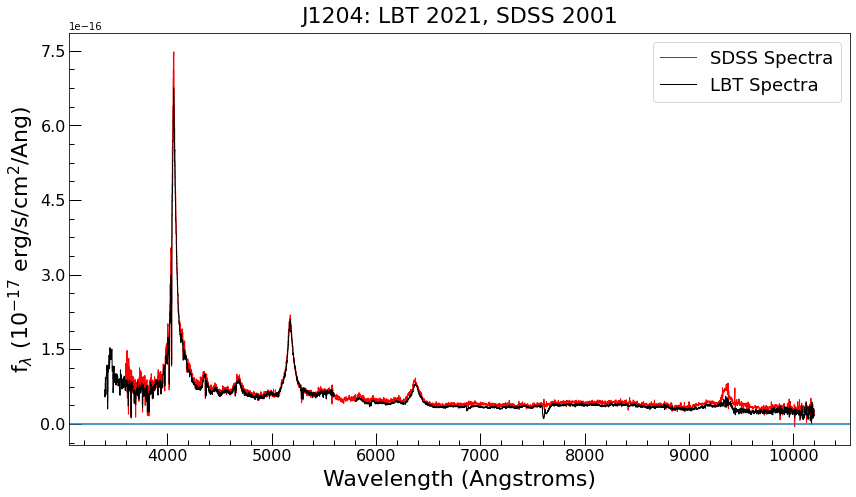

In [17]:
# ---------------------------------------------------------
# Graphing the final spectrum
# ---------------------------------------------------------


f, ax = plt.subplots(figsize=(12,7))

# ax.step(Mods1bResamp.spectral_axis, redRatio * Mods1bResamp.flux, color = "black",  linewidth=1, label="LBT Mods 1")
# ax.step(Mods1rResamp.spectral_axis, redRatio * Mods1rResamp.flux, color = "black",  linewidth=1)
# ax.step(Mods2bResamp.spectral_axis, Mods2redRatio * Mods2bResamp.flux, color = "blue",  linewidth=1, label="LBT Mods 2")
# ax.step(Mods2rResamp.spectral_axis, Mods2redRatio * Mods2rResamp.flux, color = "blue",  linewidth=1)
if SDSSexists:
    ax.step(SDSSIntResamp.spectral_axis, SDSSIntResamp.flux, color = "red",  linewidth=1, label="SDSS Spectra")
ax.step(finalSpecResamp.spectral_axis, finalSpecResamp.flux, color = "black",  linewidth=1, label="LBT Spectra")
# ax.step(finalSpecResamp.spectral_axis, clippedSpec, color = "green",  linewidth=1, label="Combined MODS")



plt.xlabel(r'Wavelength (Angstroms)',fontsize=22, labelpad=6)
plt.ylabel(r'f$_{\lambda}$ (10$^{-17}$ erg/s/cm$^2$/Ang)',fontsize=22, labelpad=4)
plt.legend(loc="upper right")
plt.tick_params(which='major', axis='both',length=12, width=1, labelsize=16)
plt.tick_params(which='minor', axis='both',length=5, width=1, labelsize=16)
plt.gca().xaxis.set_major_locator(MaxNLocator(nbins=8, prune='lower'))
plt.gca().yaxis.set_major_locator(MaxNLocator(nbins=6))
# plt.xlim(7600, 8400)  #3400, 8800
# plt.ylim(0, 1.5e-16)
plt.axhline(y=0)
plt.legend(loc="upper right", fontsize = 18)
plt.annotate('SDSS', xy = (0, 0), xytext = (0.5, 0.5), size=22, textcoords = 'axes fraction', ha = 'left', va = 'center', color='black')
plt.title(str(currentObject) + ': LBT 2021, SDSS 2001',fontsize=22, y=1.01)
plt.minorticks_on()
plt.tight_layout()
plt.savefig(str(currentObject) + 'finalComparison.pdf', dpi=300)

# Creating an ASCII table of the data we have.

Before you run this block of code, run the following line of code within your command prompt.

$ pip install prettytable

In [18]:
# importing required library
from prettytable import PrettyTable
  
# creating an empty PrettyTable
objectAscii = PrettyTable()
SDSSAscii = PrettyTable()

# adding data into the table
# row by row
objectAscii.field_names = ["Wavelength (Angstroms)", "Flux (erg/s/cm2/A)"]
SDSSAscii.field_names = ["Wavelength (Angstroms)", "Flux (erg/s/cm2/A)"]

# print(f"{finalSpecResamp.flux[i]:.4e}"[:10])

for i in range(len(finalSpecResamp.spectral_axis)):
    if f"{finalSpecResamp.flux[i]}" == "nan erg / (Angstrom cm2 s)":
        objectAscii.add_row([f"{finalSpecResamp.spectral_axis[i]:.3f}"[:7], 0])
    else:
        objectAscii.add_row([f"{finalSpecResamp.spectral_axis[i]:.3f}"[:7], f"{finalSpecResamp.flux[i]:.4e}"[:11]]) 
  
if SDSSexists:
    for i in range(len(finalSpecResamp.spectral_axis)):
        if f"{SDSSIntResamp.flux[i]}" == "nan erg / (Angstrom cm2 s)":
            SDSSAscii.add_row([f"{SDSSIntResamp.spectral_axis[i]:.3f}"[:7], 0])
        else:
            SDSSAscii.add_row([f"{SDSSIntResamp.spectral_axis[i]:.3f}"[:7], f"{SDSSIntResamp.flux[i]:.4e}"[:11]])
            
    with open(f'SDSS_{currentObject}.csv', 'w', newline='') as SDSS_output:
        SDSS_output.write(SDSSAscii.get_csv_string(delimiter = ' '))
    
with open(f'{currentObject}.csv', 'w', newline='') as obj_output:
    obj_output.write(objectAscii.get_csv_string(delimiter = ' '))
    

    
print(objectAscii)

+------------------------+--------------------+
| Wavelength (Angstroms) | Flux (erg/s/cm2/A) |
+------------------------+--------------------+
|        3400.00         |         0          |
|        3401.50         |    6.8573e-17      |
|        3403.00         |    5.4371e-17      |
|        3404.50         |    5.8007e-17      |
|        3406.00         |    8.1664e-17      |
|        3407.50         |    9.3008e-17      |
|        3409.00         |    6.9524e-17      |
|        3410.50         |    5.9127e-17      |
|        3412.00         |    6.0739e-17      |
|        3413.50         |    8.9234e-17      |
|        3415.00         |    9.4230e-17      |
|        3416.50         |    9.8889e-17      |
|        3418.00         |    9.8210e-17      |
|        3419.50         |    1.0260e-16      |
|        3421.00         |    1.0524e-16      |
|        3422.50         |    1.1825e-16      |
|        3424.00         |    1.0690e-16      |
|        3425.50         |    1.1113e-16